# wk11 Demo - ALS
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

Last week we did pagerank. This week we're doing Alternating Least Squares (ALS) Regression. 

In class today we'll start out with some basic theory of ALS using Spark. We'll do all of these with closed-form ridge regression (l2) starting with a single node implementation, distributed implementation, and a mllib implementation. 

By the end of today's demo you should be able to:  
* ... __describe__ ALS regression 
* ... __implement__ ALS regression in a distributed fashion.
* ... __explain__ how the implementation between single node and distributed differ.

__`Additional Resources:`__ This notebook was based on several notebooks by Jimi and the following references:
- https://bugra.github.io/work/notes/2014-04-19/alternating-least-squares-method-for-collaborative-filtering/
- https://web.stanford.edu/~rezab/classes/cme323/S15/notes/lec14.pdf
- Matrix Completion and Low-Rank SVD via Fast Alternating Least Squares (https://arxiv.org/pdf/1410.2596.pdf)
- https://blog.insightdatascience.com/explicit-matrix-factorization-als-sgd-and-all-that-jazz-b00e4d9b21ea
- http://yifanhu.net/PUB/cf.pdf
- http://math.bu.edu/people/cgineste/classes/ma575/p/w14_1.pdf

### Notebook Set-Up

In [2]:
# imports
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import path

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
from pyspark.sql import SparkSession
app_name = "wk4_demo"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [5]:
# make data directory if it doesn't already exist
!mkdir -p data
!curl https://www.dropbox.com/s/yk72grsouyw018l/test.data.txt?dl=1 -o data/test.data
!curl http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o data/data-ml-latest-small.zip
!curl http://files.grouplens.org/datasets/movielens/ml-10m.zip -o data/data-ml-10m.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0   198k      0  0:00:04  0:00:04 --:--:--  216k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 62.5M  100 62.5M    0     0   615k      0  0:01:43  0:01:43 --:--:-- 1139k


In [6]:
!rm -rf data/ml*
!unzip data/data-ml-latest-small.zip -d data/
!unzip data/data-ml-10m.zip -d data/

Archive:  data/data-ml-latest-small.zip
   creating: data/ml-latest-small/
  inflating: data/ml-latest-small/links.csv  
  inflating: data/ml-latest-small/tags.csv  
  inflating: data/ml-latest-small/ratings.csv  
  inflating: data/ml-latest-small/README.txt  
  inflating: data/ml-latest-small/movies.csv  
Archive:  data/data-ml-10m.zip
   creating: data/ml-10M100K/
  inflating: data/ml-10M100K/allbut.pl  
  inflating: data/ml-10M100K/movies.dat  
  inflating: data/ml-10M100K/ratings.dat  
  inflating: data/ml-10M100K/README.html  
  inflating: data/ml-10M100K/split_ratings.sh  
  inflating: data/ml-10M100K/tags.dat  


In [8]:
!tree data/

data/
|-- data-ml-10m.zip
|-- data-ml-latest-small.zip
|-- ml-10M100K
|   |-- README.html
|   |-- allbut.pl
|   |-- movies.dat
|   |-- ratings.dat
|   |-- split_ratings.sh
|   `-- tags.dat
|-- ml-latest-small
|   |-- README.txt
|   |-- links.csv
|   |-- movies.csv
|   |-- ratings.csv
|   `-- tags.csv
`-- test.data

2 directories, 14 files


## What's the problem

A lot of marketing in todays world relies on putting eyes on products people want to buy; however, with a new customer or a new product you don't have enough information to make recommendations effectively. This is called the cold start problem. These products could be movies, eletronics, news, etc. effectively anything that can be consumed by a customer.

Given a customer you have ratings/likes/mentions/views they've given a product and your goal is to determine which to show them next.

You could represent this in a $n\times m$ rating's matrix $R$ with entries $r_{u,i}$ representing the $i$th item rating by user $u$ with $n$ users and $m$ items

A common approach for this problem is matrix factorization where we make estimates for the complete ratings matrix $R$ in terms of two matrix "factors" $X$ and $Y$ which multiply together to form $R$. Where $X$ is the user matrix and $Y$ is the item matrix.

$$
R \approx X^{T}Y
$$

## Theory

Goal: Estimate R by creating factor matricies with reduced complexity $X\in\mathbb{R}^{k,n}$ and $Y\in\mathbb{R}^{k,m}$ with $n$ users, $m$ items, and $k$ factors. 

#### Assumptions
- Each user can be described by $k$ attributes or features. For example, feature 1 might be a number that says how much each user likes sci-fi movies; however, they are ambiguous since the model derives them similar to a neural network. So we do not get the interpretability.
- Each item (movie) can be described by an analagous set of $k$ attributes or features. To correspond to the above example, feature 1 for the movie might be a number that says how close the movie is to pure sci-fi.
- If we multiply each feature of the user by the corresponding feature of the movie and add everything together, this will be a good approximation for the rating the user would give that movie.

$$
r'_{u,i} = \boldsymbol{x}^{T}_{u}\boldsymbol{y}_{i} = \sum_{k} x_{u,k}y_{k,i}
$$

These user and item vectors are often called latent vectors or low-dimensional embeddings.


#### Loss

Let's do RMSE for our loss and add in regularization for generalizability

$$
\DeclareMathOperator{\Tr}{Tr}
\begin{align}
L &= \Vert R-R' \Vert^{2} + \lambda \Vert R'\Vert^{2} \\
&= \Vert R-X^{T}Y \Vert^{2} + \lambda \Vert X^{T}Y\Vert^{2}
\end{align}
$$

or in vector notation

$$
\begin{align}
L &=\sum_{u,i}\left(\Vert r_{u,i}-r'_{u,i} \Vert^{2} +\lambda \Vert r'_{u,i} \Vert^{2}\right) \\
&=\sum_{u,i}\left(\Vert r_{u,i}-\boldsymbol{x}_{u}^{T}\boldsymbol{y}_{i} \Vert^{2}\right) + \lambda \Vert \boldsymbol{x}_{u}^{T}\boldsymbol{y}_{i}\Vert^{2}
\end{align}
$$

Notice that $X^{T}Y$ are multiplied. This means the space isn't convex. (get picture). Also minimizing this is hard. How can we change the user space and the item space in relation to each other? Let's make an assumption to make our life easier. It turns out if we constrain $X$ ($X^{T}$ by proxy) or $Y$ to be constant, that this is a convex problem since the multiplicative factor is a constant and it has the same matrix notation as standard least square regression.

If $X$ is constant and we only have regularization in items

$$
\begin{align}
L &= \Vert R-xY \Vert^{2} + \lambda \Vert Y\Vert^{2} \\
&= \Vert R-xY \Vert^{2} + \lambda y^{T}y \\
\frac{\partial}{\partial y}L &= 2x
\end{align}
$$

If $Y$ is constant and we only have regularization in users

$$
\begin{align}
L &= \Vert R-yX^{T} \Vert^{2} + \lambda \Vert X\Vert^{2} \\
\frac{\partial}{\partial x}L &=
\end{align}
$$

#### Alternating Least Squares

...

## About the Data

...

## Python - Single Node Implementation

In [1]:
baseDir = f"{PWD}/data/ml-10M100K"

# The MovieLens dataset contains 10000054 ratings and 95580 tags applied to 10681 movies by 71567 users.

rating_headers = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table(path.join(baseDir,'ratings.dat'), sep='::', header=None, names=rating_headers)

movie_headers = ['movie_id', 'title', 'genres']
movies = pd.read_table(path.join(baseDir,'movies.dat'), sep='::', header=None, names=movie_headers)
movie_titles = movies.title.tolist()

df = movies.join(ratings, on=['movie_id'], rsuffix='_r')
del df['movie_id_r']
df.head()

NameError: name 'PWD' is not defined

In [6]:
# Getting Q Matrix
rp = df.pivot_table(columns=['movie_id'],index=['user_id'],values='rating').fillna(0)
rp.head()
Q = rp.values
Q.shape

(303, 10681)

In [7]:
# build a binary weight matrix (so the algo focuses on say the movies a user rated during each subproblem 
# (each user can be view as an atomic problem to be solved) that is solved)
W = Q>0.5
W[W == True] = 1
W[W == False] = 0
# To be consistent with our Q matrix
W = W.astype(np.float64, copy=False)
lambda_ = 0.1 # learning rate
n_factors = 100
m, n = Q.shape

#setup user and movie factor matrices of order n_factors between [0, 5] stars
X = 5 * np.random.rand(m, n_factors) 
Y = 5 * np.random.rand(n_factors, n)
X.shape

#compute the error (Frobenus norm) where
# Q target ratings matrix
# X and Y are the factorized matrices
# W weight matrix
def get_error(Q, X, Y, W):
    return np.sum((W * (Q - np.dot(X, Y)))**2)

print(W)

[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]]


In [8]:
# non-weighted version of ALS (does not work well!)
# uses all user item values (as opposed to the subset of actual ratings)
n_iterations = 20

errors = []
for i in range(n_iterations):
    X = np.linalg.solve(np.dot(Y, Y.T) + lambda_ * np.eye(n_factors), 
                        np.dot(Y, Q.T)).T
    Y = np.linalg.solve(np.dot(X.T, X) + lambda_ * np.eye(n_factors),
                        np.dot(X.T, Q))
    print(f'{i}th iteration is completed')
    errors.append(get_error(Q, X, Y, W))
Q_hat = np.dot(X, Y)

print('')
print(f'Error of rated movies: {get_error(Q, X, Y, W)}')

0th iteration is completed
1th iteration is completed
2th iteration is completed
3th iteration is completed
4th iteration is completed
5th iteration is completed
6th iteration is completed
7th iteration is completed
8th iteration is completed
9th iteration is completed
10th iteration is completed
11th iteration is completed
12th iteration is completed
13th iteration is completed
14th iteration is completed
15th iteration is completed
16th iteration is completed
17th iteration is completed
18th iteration is completed
19th iteration is completed

Error of rated movies: 15742.610437641586


Text(0,0.5,'Total Squared Error')

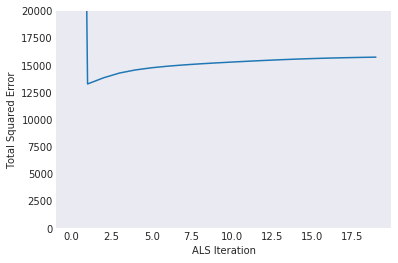

In [9]:
import matplotlib.pyplot as plt
# display plots inline (otherwise it will fire up a separate window)
%matplotlib inline
plt.plot(errors);
plt.ylim([0, 20000]);
plt.ylim([0, 20000]);
plt.xlabel("ALS Iteration")
plt.ylabel("Total Squared Error")

0th iteration is completed
1th iteration is completed
2th iteration is completed
3th iteration is completed
4th iteration is completed
5th iteration is completed
6th iteration is completed
7th iteration is completed
8th iteration is completed
9th iteration is completed
10th iteration is completed
11th iteration is completed
12th iteration is completed
13th iteration is completed
14th iteration is completed
15th iteration is completed
16th iteration is completed
17th iteration is completed
18th iteration is completed
19th iteration is completed
Error of rated movies: 10.103730329407346


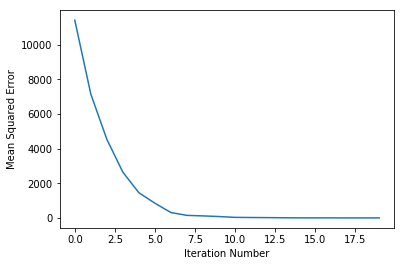

In [17]:
weighted_errors = []
for ii in range(n_iterations):
    for u, Wu in enumerate(W):
        #AX=B =>  X=A^-1B ; in python use solve(A, B) 
        X[u] = np.linalg.solve(np.dot(Y, np.dot(np.diag(Wu), Y.T)) + lambda_ * np.eye(n_factors),
                               np.dot(Y, np.dot(np.diag(Wu), Q[u].T))).T
    for i, Wi in enumerate(W.T):
        Y[:,i] = np.linalg.solve(np.dot(X.T, np.dot(np.diag(Wi), X)) + lambda_ * np.eye(n_factors),
                                 np.dot(X.T, np.dot(np.diag(Wi), Q[:, i])))
    weighted_errors.append(get_error(Q, X, Y, W))
    print(f'{ii}th iteration is completed')
weighted_Q_hat = np.dot(X,Y)
print(f'Error of rated movies: {get_error(Q, X, Y, W)}')
plt.plot(weighted_errors);
plt.xlabel('Iteration Number');
plt.ylabel('Mean Squared Error');

## Spark - Distributed Implementation

In [10]:
import numpy as np
from numpy.random import rand
from numpy import matrix

In [11]:
def rmse(R, U, V): # Metric
    return np.sqrt(np.sum(np.power(R-U*V, 2))/(U.shape[0]*V.shape[1]))

In [12]:
def solver(mat, R, LAMBDA):  # solver to get R*mat(matT*mat + lambda*I)^-1
    d1 = mat.shape[0]
    d2 = mat.shape[1]

    X2 = mat.T * mat
    XY = mat.T * R.T

    for j in range(d2):
        X2[j, j] += LAMBDA * d1

    return np.linalg.solve(X2, XY)

In [21]:
# Not only caculation is paralleized but also the data is wisely partitioned and shared to improve locality.
def closedFormALS(R,InitialU,InitialVt,rank,iterations,numPartitions,LAMBDA=0.01):
    R_Userslice = sc.parallelize(R,numPartitions).cache() # R will automaticly be partitioned by row index
    R_Itemslice = sc.parallelize(R.T,numPartitions).cache() # R_T will automaticly be partitioned by row index
    U = InitialU
    Vt = InitialVt
    
    for i in range(iterations):
        
        print(f"Iteration: {i}")
        print(f"RMSE: {rmse(R, U, Vt.T)}")
        
        Vtb = sc.broadcast(Vt)
        U3d = R_Userslice.map(lambda x:solver(Vtb.value,x,LAMBDA)).collect() # a list of two 2-D matrix
        U = matrix(np.array(U3d)[:, :, 0]) # transfered to 2-D matrix
        
        Ub = sc.broadcast(U)
        Vt3d = R_Itemslice.map(lambda x:solver(Ub.value,x,LAMBDA)).collect() # a list of two 2-D matrix
        Vt = matrix(np.array(Vt3d)[:, :, 0])  # transfered to 2-D matrix
    
    return U, Vt 

In [20]:
# Only parallelize the calculation. It does not consider the data transmission cost
def simpleParalleling(R,InitialU,InitialVt,rank,iterations,numPartitions,LAMBDA=0.01):
    Rb = sc.broadcast(R)
    U = InitialU
    Vt = InitialVt
    Ub = sc.broadcast(U)
    Vtb = sc.broadcast(Vt)
    numUsers = InitialU.shape[0]
    numItems = InitialVt.shape[0]
    
    for i in range(iterations):
        print(f"Iteration: {i}")
        print(f"RMSE: {rmse(R, U, Vt.T)}")
        U3d = sc.parallelize(range(numUsers), numPartitions) \
           .map(lambda x: solver( Vtb.value, Rb.value[x, :],LAMBDA)) \
           .collect() # a list of two 2-D matrix
        U = matrix(np.array(U3d)[:, :, 0]) # transfered to 2-D matrix
        Ub = sc.broadcast(U)

        Vt3d = sc.parallelize(range(numItems), numPartitions) \
           .map(lambda x: solver(Ub.value, Rb.value.T[x,:],LAMBDA)) \
           .collect() # a list of two 2-D matrix
        Vt = matrix(np.array(Vt3d)[:, :, 0]) # transfered to 2-D matrix
        Vtb = sc.broadcast(Vt)
    return U, Vt

In [24]:
def main():
    LAMBDA = 0.01   # regularization parameter
    np.random.seed(100)
    numUsers = 5000
    numItems = 100
    rank = 10
    iterations = 5
    numPartitions = 4

    trueU = matrix(rand(numUsers, rank)) #True matrix U to generate R
    trueV = matrix(rand(rank, numItems)) #True matrix V to generate R
    R = matrix(trueU*trueV)   #generate Rating matrix
    
    InitialU = matrix(rand(numUsers, rank)) #Initialization of U
    InitialVt = matrix(rand(numItems,rank)) #Initialization of V
    
    print(f"Running ALS with numUser={numUsers}, numItem={numItems}, rank={rank}, iterations={n_iterations}, numPartitions={numPartitions}")
    
    print("Distributed Version---Two copies of R, one is partitioned by rowIdx, the other is partitioned by colIndx")
    closedFormALS(R,InitialU,InitialVt,rank,n_iterations,numPartitions,LAMBDA)
    
    print("Simple paralleling ---Suppose User Matrix R is small enough to be broadcast")
    simpleParalleling(R,InitialU,InitialVt,rank,n_iterations,numPartitions,LAMBDA)

In [25]:
main()

Running ALS with numUser=5000, numItem=100, rank=10, iterations=20, numPartitions=4
Distributed Version---Two copies of R, one is partitioned by rowIdx, the other is partitioned by colIndx
Iteration: 0
RMSE: 0.9815230991941133
Iteration: 1
RMSE: 0.18383882868397297
Iteration: 2
RMSE: 0.04611200605830334
Iteration: 3
RMSE: 0.03816821312276148
Iteration: 4
RMSE: 0.035043154796695494
Iteration: 5
RMSE: 0.033598057357839016
Iteration: 6
RMSE: 0.032850336080172605
Iteration: 7
RMSE: 0.0324310726874492
Iteration: 8
RMSE: 0.03218314707137557
Iteration: 9
RMSE: 0.032031533454156776
Iteration: 10
RMSE: 0.03193677888775011
Iteration: 11
RMSE: 0.03187661225052937
Iteration: 12
RMSE: 0.031837862070997924
Iteration: 13
RMSE: 0.03181251335254612
Iteration: 14
RMSE: 0.03179560608548407
Iteration: 15
RMSE: 0.03178404039369791
Iteration: 16
RMSE: 0.03177586755251728
Iteration: 17
RMSE: 0.031769858072190627
Iteration: 18
RMSE: 0.031765234398224276
Iteration: 19
RMSE: 0.03176150394113226
Simple paralleli

## Spark - Spark ML implementation